<a href="https://colab.research.google.com/github/adifatol/BIQA/blob/master/convNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
!ls blur

ls: cannot access 'blur': No such file or directory


# Upload Images

shows a dialog to upload new images

option to download the CSIQ Image Quality Database

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [3]:
import os

if not (
  os.path.exists("blur") and
  os.path.exists("contrast") and
  os.path.exists("jpeg") and
  os.path.exists("jpeg2000") and
  os.path.exists("fnoise")
):
  !wget http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
  !wget http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip

  !unzip -n src_imgs.zip
  !unzip -n dst_imgs.zip
else:
  print("images found, skipping.")

--2019-06-25 15:20:50--  http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14455692 (14M) [application/zip]
Saving to: ‘src_imgs.zip’

src_imgs.zip        100%[===================>]  13.79M  6.28MB/s    in 2.2s    

2019-06-25 15:20:53 (6.28 MB/s) - ‘src_imgs.zip’ saved [14455692/14455692]

--2019-06-25 15:20:53--  http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374383009 (357M) [application/zip]
Saving to: ‘dst_imgs.zip’

dst_imgs.zip        100%[===================>] 357.04M  11.2MB/s    in 33s     

2019-06-25 1

# Load Images in colab

loads images of a certain SHAPE into runtime memory

In [4]:

import os

# List Image Names
# Parses each file name of format <NAME>.png
# TODO: support for other extensions?
def image_list( ext = '.png'):
  names = {}
  for f in [file for file in os.listdir() if file.endswith(ext)]:
    fname = os.path.splitext(f)[0]
    names[fname] = 1
  return list(names.keys())

img_list = image_list()
print('Images found: ', img_list)

Images found:  ['monument', 'redwood', 'elk', 'rushmore', 'family', 'snow_leaves', 'cactus', 'lady_liberty', 'native_american', 'swarm', 'veggies', 'butter_flower', 'aerial_city', 'boston', 'shroom', 'lake', 'trolley', 'turtle', '1600', 'woman', 'child_swimming', 'fisher', 'couple', 'log_seaside', 'sunsetcolor', 'sunset_sparrow', 'foxy', 'bridge', 'roping', 'geckos']


In [5]:

# Load the images
# Encode them into jpg

DISTORT = ['blur','contrast','fnoise', 'jpeg', 'jpeg2000']
DISTORT_EXT = ['BLUR','contrast','fnoise', 'JPEG', 'jpeg2000']
Q_LEVELS = ['1','2','3','4','5']
NR_IMG = 20 # 'ALL' 10, 20 ...

if NR_IMG == 'ALL':
  NR_IMG = len(img_list)

print(NR_IMG)

from random import randint
import numpy as np
import cv2

#TODO support for nItems = 'ALL'
#TODO support various loading order (randomize?)
def load_imgs(img_list, nItems):
  
  images = {}
  images['orig'] = []
  for dist in DISTORT:
    images[dist] = {}
    for qlvl in Q_LEVELS:
      images[dist][qlvl] = []

  for f in range(0,nItems):
    fname = img_list[f]
    original = fname+'.png'
    img_data = cv2.imread(original)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images['orig'].append(img_data)
    for dist, d_ext in zip(DISTORT, DISTORT_EXT):
      for qlvl in Q_LEVELS:
        f_path = dist+'/'+fname+'.'+d_ext+'.'+qlvl+'.png'
        img_data = cv2.imread(f_path)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        images[dist][qlvl].append(img_data)
  return images

images = load_imgs(img_list, NR_IMG)

print("Nr of img:",len(images['orig']))


20
Nr of img: 20


In [0]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_all(arr_of_images, patch_estimator=False):
  columns = 5
  spacing = 14.75
  minorLocator = MultipleLocator(spacing)
  fig = plt.figure(figsize=(20,10))
  for i, image in enumerate(arr_of_images):
    ax = fig.add_subplot(len(images) / columns + 1, columns, i + 1)
    if patch_estimator:
      ax.yaxis.set_minor_locator(minorLocator)
      ax.xaxis.set_minor_locator(minorLocator)
      ax.grid(which = 'minor')
    plt.imshow(image)
  plt.show()


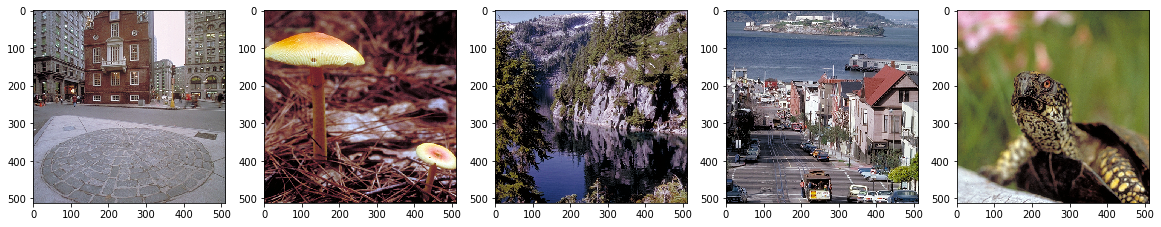

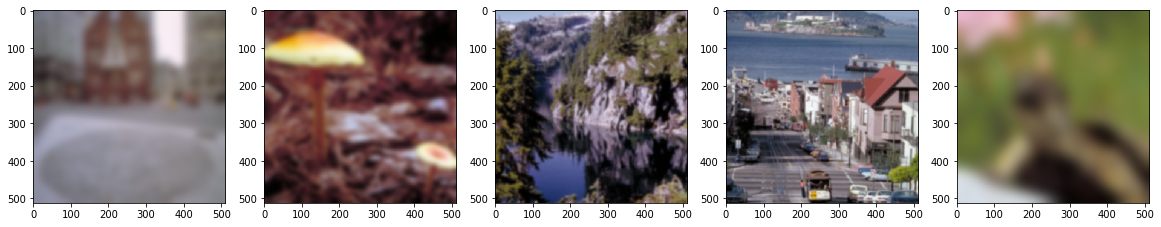

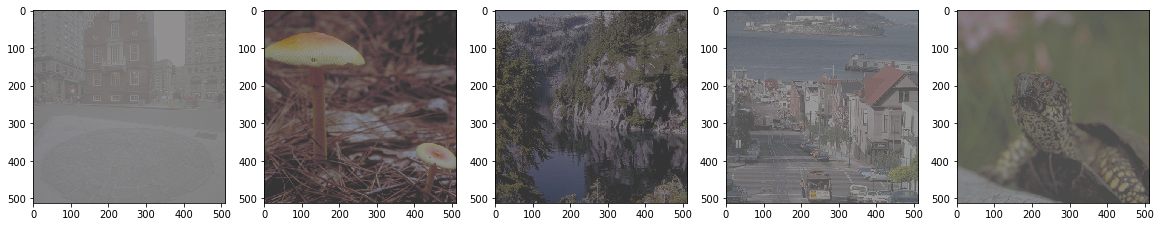

In [7]:
#Print some stats
max_to_show = min(NR_IMG,5)
rand_idx = randint(0, len(images['orig'])-max_to_show)
plot_all(images['orig'][rand_idx:rand_idx+max_to_show])
plot_all(images['blur']['5'][rand_idx:rand_idx+max_to_show])
plot_all(images['contrast']['5'][rand_idx:rand_idx+max_to_show])


# Score Images

apply the method suggested in [Learning without Human Scores for Blind Image Quality Assessment](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Xue_Learning_without_Human_2013_CVPR_paper.pdf)

## Extract Patches and calculate {SSIM} score

In [8]:
!pip install tqdm

In [9]:
#Calculate the number of patches


OWH = 512 # 512 x 512
WH = 28 #
WINDOW_SHAPE = (WH,WH,3)
PATCH_COUNT = int(int(OWH / WH) * int(OWH / WH))

print(PATCH_COUNT)

324


In [10]:
from skimage.measure import compare_ssim
from skimage.util.shape import view_as_windows
from tqdm import tqdm

def plot_patches(patches):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 1
  rows = 1
  for i in range(1, columns*rows +1):
      img = patches[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

def extract_patches(img):
  patches = np.squeeze(view_as_windows(img, WINDOW_SHAPE,step=WH))
  patches = np.reshape(patches,(-1,WH,WH,3))
  patches = np.sum(patches/3, axis=3, keepdims=True)
  return patches

dim_len, dim_dist, dim_q = len(images['orig']), len(DISTORT), len(Q_LEVELS);
test_len = dim_len

one_score = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
scores = [np.copy(one_score) for x in range(test_len)]
all_patches = []

for i in tqdm(range(len(images['orig'][:test_len]))):
  img = images['orig'][i]
  orig_patches = extract_patches(img)
  for idist, dist in enumerate(DISTORT):
    for iqlvl, qlvl in enumerate(Q_LEVELS):
      dist_img = images[dist][qlvl][i]
      distorted_patches = extract_patches(dist_img)
      local_scores = np.zeros(PATCH_COUNT)
      local_patches = []
      for j in range(PATCH_COUNT):
        orig_patch = orig_patches[j]
        dist_patch = distorted_patches[j]
        (score, diff) = compare_ssim(orig_patch, dist_patch, full=True, multichannel=True)
        local_scores[j] = (score + 1) / 2
        all_patches.append(dist_patch)
      scores[i][idist][iqlvl] = np.copy(local_scores)

#   plot_patches(orig_patches)
#   for patch in orig_patches:
#   (score, diff) = compare_ssim(dist_img, img, full=True, multichannel=True)
#   diff = (diff * 255).astype("uint8")
#   print("___")
#   print("SSIM: {}".format(score))


100%|██████████| 20/20 [00:43<00:00,  2.23s/it]


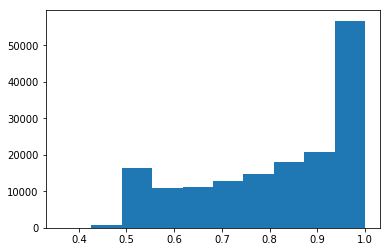

0.3623808596584809

In [11]:
plt.hist(np.array(scores).flatten())
plt.show()

min(np.array(scores).flatten())

## Calculate the C constant (![alt text](https://latex.codecogs.com/gif.latex?c%20%3D%20%5Cfrac%7B%5Csum%20_%7Bi%5Cepsilon%20%5COmega%7DS_%7Bi%7D%20%7D%7B10*%5Csum%20_%7Bi%5Cepsilon%20%5COmega_%7Bp%7D%7DS_%7Bi%7D%7D))

In [0]:
def the_C_constant(batch):
  all_sum = sum(batch)
  percentile = 50
  batch_percentile = np.percentile(batch,percentile)
  omega_p_sum = sum([i for i in batch if i <= batch_percentile])
  c = all_sum / (percentile * omega_p_sum)
  return c
# the_C_constant(scores[0][0][0])

## Histograms for scores

(20, 5, 5, 324)
0.04549817115082892
comparing for 9
(img-9 dist-3 qual-4)


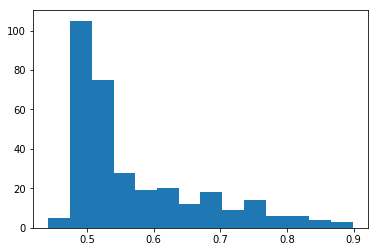

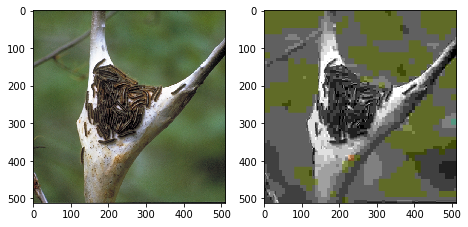

In [13]:
#Random scores visualisations

from mpl_toolkits.mplot3d import Axes3D

def histogram(img_idx, img_dist, img_qual):
  print("comparing for {}".format(img_idx))
  print("(img-{} dist-{} qual-{})".format(img_idx, img_dist, img_qual))
  plt.hist(scores[img_idx][img_dist][img_qual], bins='auto')
  plt.show()

ri = randint(0,dim_len-1)
rd = randint(0,dim_dist-1)
rq = randint(0,dim_q-1)

print(np.array(scores).shape)

for i in range(ri,ri+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      c = the_C_constant(scores[i][d][q])
      print(c)
      histogram(ri,rd,rq)
      plot_all([images['orig'][i],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])


## Normalize scores

In [0]:
norm_scores = np.copy(scores)
for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
      c = the_C_constant(scores[i][d][q])
      norm_scores[i][d][q][:] = [x / c for x in norm_scores[i][d][q]]
norm_scores = np.interp(norm_scores, (norm_scores.min(), norm_scores.max()), (0, +1))


(img-9 dist-jpeg qual-5)


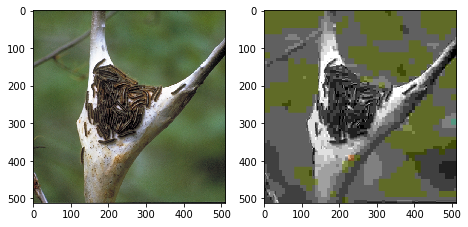

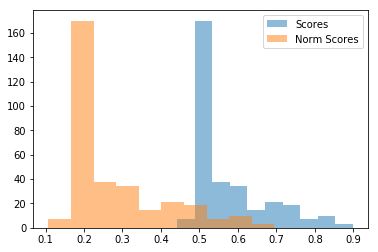

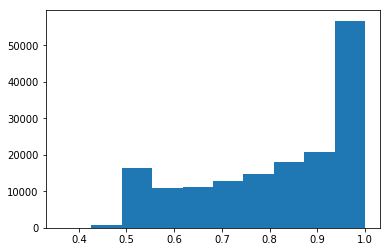

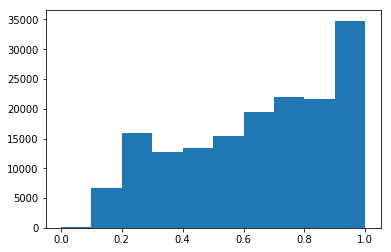

min scores 0.3623808596584809, min norm_scores 0.0, max scores 1.0, max norm_scores 1.0


In [15]:
print("(img-{} dist-{} qual-{})".format(ri, DISTORT[rd], Q_LEVELS[rq]))


plot_all([images['orig'][ri],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.legend(loc='upper right')
plt.show()

plt.hist(np.array(scores).flatten())
plt.show()
plt.hist(np.array(norm_scores).flatten())
plt.show()

print("min scores {}, min norm_scores {}, max scores {}, max norm_scores {}".format(min(np.array(scores).flatten()), min(np.array(norm_scores).flatten()), max(np.array(scores).flatten()), max(np.array(norm_scores).flatten())))

## Score QAC - Quality Aware Clusters

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
(20, 5, 5, 324)
(5, 5, 324)
(20, 5, 5, 324)


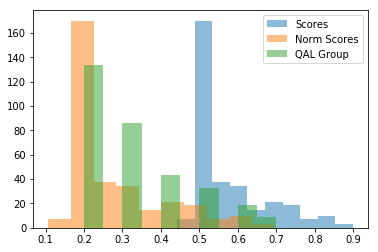

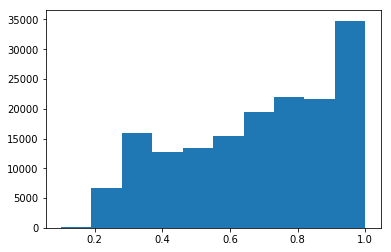

In [16]:
# Define The Score Levels used in QAC

L = 10 # The Score Levels used in QAC
Gl = list(range(1,L+1))
Gl[:] = [x / L for x in Gl]

one_group = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
G = [np.copy(one_group) for x in range(dim_len)]

print(Gl)
print(np.array(G).shape)
print(np.array(one_group).shape)
print(np.array(norm_scores).shape)

for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
# for i in range(ri,i+1):
#   for d in range(rd,rd+1):
#     for q in range(rq,rq+1):
      for p,score in enumerate(norm_scores[i][d][q]):
        G[i][d][q][p] = Gl[L-1]
        for score_l in Gl:
          if score <= score_l:
            G[i][d][q][p] = score_l
            break

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.hist(G[ri][rd][rq], alpha=0.5, label='QAL Group')
plt.legend(loc='upper right')
plt.show()

plt.hist(np.array(G).flatten())
plt.show()

## Convolutional network with Keras

## High pass filter - Difference of Gaussian (DoG) ( ![alt text]( https://latex.codecogs.com/gif.latex?h_%7B%5Csigma%20%7D%28r%29%3D1_%7Br%3D0%20%7D-%5Cfrac%7B1%7D%7B%5Csqrt%7B2%5Cpi%20%5Csigma%20%7D%7Dexp%28-%5Cfrac%7Br%5E%7B2%7D%7D%7B2%5Csigma%20%5E%7B2%7D%7D%29) )

In [17]:
from skimage import filters, color

def dog(patch, sigma):
  k = 1.6
  s1 = filters.gaussian(patch,k*sigma)
  s2 = filters.gaussian(patch,sigma)
  # multiply by sigma to get scale invariance
  dog = s1 - s2
  return dog

#Sigmas: [0.2, 2.0, 4.0]

def all_filtered_patches(all_patches, sigma):
  all_filtered = []
  for i in tqdm(range(len(all_patches))):
    patch = all_patches[i]
#     gray_patch = color.rgb2gray(patch)
    gray_patch = patch
    filtered = dog(gray_patch, sigma)
    all_filtered.append(filtered)
  return all_filtered

# fa = all_filtered_patches(all_patches, 0.8)
fb = all_filtered_patches(all_patches, 2.0)
fc = all_filtered_patches(all_patches, 4.0)

100%|██████████| 162000/162000 [01:04<00:00, 2505.31it/s]


In [18]:

all_filtered = np.concatenate((fb, fc),axis=2)
print (np.array(all_filtered).shape)

(162000, 28, 56, 1)


### Split into training and validation

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow import keras 

all_scores = np.array(G).flatten()

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_filtered), np.array(all_scores), test_size=0.15, shuffle= True)


num_classes = 10
y_train_c = keras.utils.to_categorical(y_train, num_classes)
y_valid_c = keras.utils.to_categorical(y_valid, num_classes)

print("\ntrain:")
print(np.array(x_train).shape)
print(np.array(y_train).shape)

print("\n y categorical:")
print(np.array(y_train_c).shape)
print(np.array(y_valid_c).shape)

print("\nvalidation:")
print(np.array(x_valid).shape)
print(np.array(y_valid).shape)

print("\nTotal:")
print(np.array(all_patches).shape)
print(np.array(all_scores).shape)


train:
(137700, 28, 56, 1)
(137700,)

 y categorical:
(137700, 10)
(24300, 10)

validation:
(24300, 28, 56, 1)
(24300,)

Total:
(162000, 28, 28, 1)
(162000,)


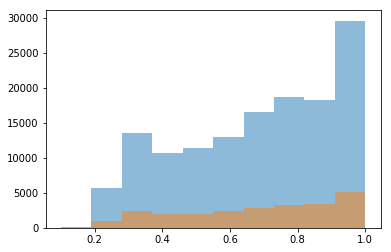

In [20]:
# import tensorflow as tf

# (x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.fashion_mnist.load_data()
# print(x_train.shape)

# x_train = np.expand_dims(x_train, -1)
# x_valid = np.expand_dims(x_valid, -1)

# print(x_train.shape)
# print(y_train.shape)
# print(y_valid.shape)

# plt.hist(y_train_c, alpha=0.5)
plt.hist(y_train, alpha=0.5)
plt.hist(y_valid, alpha=0.5)
plt.show()

In [21]:
min(y_train)

0.1

### Declare the model

In [29]:
# The model, based on https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=Zo-Yk6LFGfSf
from tensorflow.keras import layers
import tensorflow as tf
from keras.optimizers import SGD

model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) 
# Train model
sgd = SGD(lr=0.01)
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 56, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 28, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 14, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 14, 64)         18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1344)             

In [0]:


#fit the model
model.fit(x = x_train, y = y_train_c, validation_split=0.3, batch_size = 100, verbose=2, epochs=300)


Train on 96390 samples, validate on 41310 samples
Epoch 1/300
96390/96390 - 6s - loss: 0.5342 - acc: 0.7762 - val_loss: 0.4786 - val_acc: 0.7825
Epoch 2/300
96390/96390 - 6s - loss: 0.4762 - acc: 0.7835 - val_loss: 0.4750 - val_acc: 0.7834
Epoch 3/300
96390/96390 - 6s - loss: 0.4722 - acc: 0.7845 - val_loss: 0.4727 - val_acc: 0.7831
Epoch 4/300
96390/96390 - 6s - loss: 0.4694 - acc: 0.7844 - val_loss: 0.4759 - val_acc: 0.7823
Epoch 5/300
96390/96390 - 6s - loss: 0.4675 - acc: 0.7856 - val_loss: 0.4702 - val_acc: 0.7834
Epoch 6/300
96390/96390 - 6s - loss: 0.4652 - acc: 0.7860 - val_loss: 0.4707 - val_acc: 0.7839
Epoch 7/300
96390/96390 - 7s - loss: 0.4637 - acc: 0.7869 - val_loss: 0.4782 - val_acc: 0.7833
Epoch 8/300
96390/96390 - 6s - loss: 0.4618 - acc: 0.7868 - val_loss: 0.4654 - val_acc: 0.7852
Epoch 9/300
96390/96390 - 7s - loss: 0.4602 - acc: 0.7880 - val_loss: 0.4639 - val_acc: 0.7854
Epoch 10/300
96390/96390 - 7s - loss: 0.4585 - acc: 0.7887 - val_loss: 0.4632 - val_acc: 0.7845

In [24]:
#evaluate on unseen data
score = model.evaluate(x_valid, y_valid_c, verbose=1)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

24300/24300 [==============================] - 2s 69us/sample - loss: 0.4371 - acc: 0.7928
Test accuarcy: 79.28%


In [25]:
i = randint(0, x_train.shape[0]-1)
mt = [[x_train[i]]]
pred = model.predict(mt)
print(pred)
print(np.argmax(pred[0]), max(pred[0]), y_train[i])

[[8.90517235e-01 1.09391786e-01 9.28057761e-06 7.87941826e-06
  1.50787700e-05 6.57007286e-06 8.98149210e-06 1.30043036e-05
  1.14041513e-05 1.87509122e-05]]
0 0.89051723 0.5


predicting for 11742 to 11774


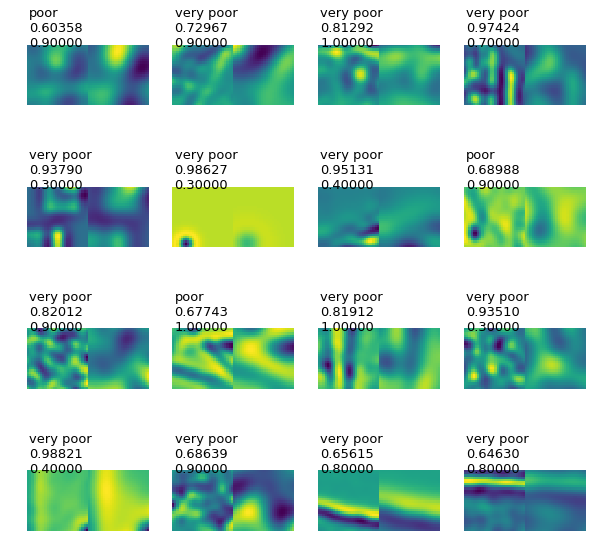

In [28]:
LABEL_NAMES = ['very poor', 'poor', 'better', 'ok', 'very ok', 'super ok', 'good', 'very good', 'super good', 'extraordinary']

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, orig_labels):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')

    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.5f' % confidence +  '\n%.5f' % orig_labels[i], fontsize=13)

  pyplot.gcf().set_size_inches(10, 10)

nr_ex = 32
start_from = randint(0, x_valid.shape[0]-nr_ex)
# start_from = 0
print("predicting for {} to {}".format(start_from, start_from+nr_ex))

# pred_y = model.predict(x_valid[start_from:start_from+nr_ex])

# max_pred = [np.argmax(y) for y in pred_y]
# print(max_pred)
# print(y_valid_oh[start_from:start_from+nr_ex])

plot_predictions(np.squeeze(x_valid[start_from:start_from+16]), model.predict(x_valid[start_from:start_from+16]), y_valid[start_from:start_from+16])